In [180]:
import json
import csv
import os
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict

import pandas as pd
pd.options.mode.chained_assignment = None

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from scikit_posthocs import posthoc_dunn
from scipy.stats import shapiro, levene, kruskal, kstest, norm

import numpy as np

In [2]:
def conv(perc_str):
    intp, decp = perc_str.replace("%","").split(".")
    res = (float(intp) + float(decp)/100)/100
    return res

def conv_video(video_set):
    v = {
        'science_videos_subset_20230815_0_30_41.csv': "science",
        'us_entertainment_unique_Aug152023.csv': "entertainment",
        'faddoul_available_Aug152023.csv': "conspiracy",
        'news_subset_Sep212023.csv': "news"
    }
    return v[video_set]

def conv_loc(location):
    l = {
        'yt-east-1: us-east5-a (Columbus, Ohio)': "east",
        'yt-central-1: us-central1-a (Council Bluffs, Iowa)': "central",
        'yt-west-1: us-west1-b (The Dalles, Oregon)': "west"
    }
    return l[location]
    
    
sheet1 = pd.read_csv("YoutubeAdsExperiments_run1.csv")
sheet2 = pd.read_csv("YoutubeAdsExperiments_run2.csv")
sheet3 = pd.read_csv("YoutubeAdsExperiments_run3.csv")

sheet1["run"] =  [1]*len(sheet1)
sheet2["run"] =  [2]*len(sheet2)
sheet3["run"] =  [3]*len(sheet3)

sheet = pd.concat([sheet1, sheet2, sheet3], ignore_index=True)

sheet = sheet[sheet["Location"].notna()].reset_index(drop=True)
sheet["preroll_scam"] = sheet["preroll_scam"].apply(conv)
sheet["all_ad_rate"] = sheet["all_ad_rate"].apply(conv)
sheet["preroll_ad_rate"] = sheet["preroll_ad_rate"].apply(conv)
sheet["pr1_scam"] = sheet["pr1_scam"].apply(conv)
sheet["pr2_scam"] = sheet["pr2_scam"].apply(conv)
sheet["location"] = sheet["Location"].apply(conv_loc)
sheet["video_set"] = sheet["video_set"].apply(conv_video)
# sheet = sheet[sheet["video_set"]!="faddoul_available_Aug152023.csv"]
sheet["run_id"] = sheet["id"] + "_" + sheet["account"]
sheet = sheet.drop(columns=['id', 'account', 'headless', 'gender', 'range', 'side_scam', 'notes', 'Location'])
display(sheet)
print(sheet.columns)

,video_set,personalization_on,activity_on,pr1_count,pr2_count,pr_count,preroll_ad_rate,pr2_rate,pr1_scam,pr2_scam,preroll_scam,side_count,side_ad_rate,promoted_vid_count,all_ad_rate,run,location,run_id
0,science,True,True,147.0,89.0,236.0,0.0787,37.71%,0.0204,0.0337,0.0254,466.0,15.53%,36.0,0.2460,1,east,0904_2337_sublinears
1,science,True,False,176.0,144.0,320.0,0.1067,45.00%,0.0682,0.1042,0.0844,605.0,20.17%,15.0,0.3133,1,east,0904_2337_banachnorm
2,science,False,False,175.0,145.0,320.0,0.1067,45.31%,0.0514,0.1103,0.0781,596.0,19.87%,5.0,0.3070,1,east,0904_2337_nonconcave
3,science,True,True,135.0,83.0,218.0,0.0727,38.07%,0.0074,0.0120,0.0092,332.0,11.07%,22.0,0.1907,1,central,0904_2237_clopentopo
4,science,True,False,250.0,197.0,447.0,0.1490,44.07%,0.0360,0.0711,0.0515,531.0,17.70%,11.0,0.3297,1,central,0904_2237_affineroot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,news,True,False,146.0,89.0,235.0,0.0783,37.87%,0.1644,0.0562,0.1234,414.0,13.80%,19.0,0.2227,3,central,0929_1715_clopentopo
104,news,False,False,153.0,94.0,247.0,0.0823,38.06%,0.1503,0.0957,0.1296,591.0,19.70%,26.0,0.2880,3,central,0929_1715_kahlerform
105,news,True,True,145.0,46.0,191.0,0.0637,24.08%,0.0483,0.0652,0.0524,488.0,16.27%,55.0,0.2447,3,west,0929_1515_eigentrace
106,news,True,False,156.0,102.0,258.0,0.0860,39.53%,0.1410,0.0686,0.1124,422.0,14.07%,12.0,0.2307,3,west,0929_1515_maxiconvex


Index(['video_set', 'personalization_on', 'activity_on', 'pr1_count',
       'pr2_count', 'pr_count', 'preroll_ad_rate', 'pr2_rate', 'pr1_scam',
       'pr2_scam', 'preroll_scam', 'side_count', 'side_ad_rate',
       'promoted_vid_count', 'all_ad_rate', 'run', 'location', 'run_id'],
      dtype='object')


In [136]:
# build all_id_dicts
all_id_dict = {}

for run in range(1,4):
    run_id_list = list(sheet[sheet["run"]==run]["run_id"])
    all_id_dict.update({run: run_id_list})

# build ad catalog

db = pd.read_csv("all_labeled.csv")
display(db)

def get_label(ad_id, db):
    
    match = db[db["preroll_ad_id"]==ad_id]
    
    if len(match):
        return int(match["is_scam"].iloc[0])
    return None

all_id_dict

,preroll_ad_id,preroll_ad_video_url,preroll_ad_site,preroll_ad_card,preroll_ad_advertiser,preroll_ad_location,id,df_index,tag,is_scam,ad_order,Notes,occurences
0,Meit9MPzDkI,https://www.youtube.com/watch?v=Meit9MPzDkI,blog.onlineshoppingtools.com,Stop Overpaying blog.onlineshoppingtools.com,"AdTechNacity, LLC",United States,247,247,Software Services,1.0,2,NaN,297
1,QfT0clJas24,https://www.youtube.com/watch?v=QfT0clJas24,go.masterclass-piano.com,Learn Piano Now go.masterclass-piano.com,Creators Secrets Inc.,United States,2253,2253,Educational Services,1.0,2,false advertising https://www.reddit.com/r/Mus...,233
2,8Bwz6p1V7OM,https://www.youtube.com/watch?v=8Bwz6p1V7OM,pubprofits.com,Free Webclass pubprofits.com,PublishingLife.com LLC,United States,646,646,Business/Marketing,1.0,2,get money quick,219
3,Z_4wmnQzNEs,https://www.youtube.com/watch?v=Z_4wmnQzNEs,warthunder.com,War Thunder warthunder.com,Gaijin Distribution Korlátolt Felelősségű Társ...,Hungary,1552,1552,Games,0.0,2,NaN,167
4,V-7_VGhj6po,https://www.youtube.com/watch?v=V-7_VGhj6po,ads.google.com,Try Google Ads ads.google.com,Google LLC,United States,1184,1184,Business/Marketing,0.0,2,NaN,148
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,_7U4ObMlTx4,https://www.youtube.com/watch?v=_7U4ObMlTx4,seatosummit.com,Sea to Summit seatosummit.com,"Sea to Summit North America, LLC",United States,2393,2393,NaN,0.0,2,NaN,1
7901,nx-z1ERkDDI,https://www.youtube.com/watch?v=nx-z1ERkDDI,Visit advertiser's site,NaN,Delta Airlines,NaN,2267,2267,NaN,0.0,1,NaN,1
7902,a8fGUjw_M5w,https://www.youtube.com/watch?v=a8fGUjw_M5w,cyberpowerpc.com,CyberPowerPC cyberpowerpc.com,"WG Enterprise Group, Inc.",United States,2070,2070,NaN,0.0,2,NaN,1
7903,lgbgG9awwJw,https://www.youtube.com/watch?v=lgbgG9awwJw,cyberpowerpc.com,CyberPowerPC cyberpowerpc.com,"WG Enterprise Group, Inc.",United States,1886,1886,NaN,0.0,2,NaN,1


{1: ['0904_2337_sublinears',
  '0904_2337_banachnorm',
  '0904_2337_nonconcave',
  '0904_2237_clopentopo',
  '0904_2237_affineroot',
  '0904_2237_kahlerform',
  '0904_2037_nonlattice',
  '0904_2037_maxiconvex',
  '0904_2037_eigentrace',
  '0907_2127_nonconcave',
  '0907_2127_sublinears',
  '0907_2127_banachnorm',
  '0907_2027_affineroot',
  '0907_2027_kahlerform',
  '0907_2027_clopentopo',
  '0907_1827_eigentrace',
  '0907_1827_nonlattice',
  '0907_1827_maxiconvex',
  '0911_1713_sublinears',
  '0911_1713_nonconcave',
  '0911_1713_banachnorm',
  '0911_1613_clopentopo',
  '0911_1613_kahlerform',
  '0911_1613_affineroot',
  '0911_1413_nonlattice',
  '0911_1413_eigentrace',
  '0911_1413_maxiconvex',
  '1006_2347_banachnorm',
  '1006_2347_nonconcave',
  '1006_2347_sublinears',
  '1006_2247_kahlerform',
  '1006_2247_clopentopo',
  '1006_2247_affineroot',
  '1006_2047_maxiconvex',
  '1006_2047_eigentrace',
  '1006_2047_nonlattice'],
 2: ['0916_0125_banachnorm',
  '0916_0125_sublinears',
  '09

In [130]:
# update results in the sheet from actual data instead of from csv

# generate all run dfs with repetitions
run_dfs = []

for run in range(1,4):

    run_ids = all_id_dict[run]
    df_list = []

    for id in run_ids:
        unavailable_count = 0
        available_count = 0

        ad_dir = f"run{run}"
        ads_file = f"{ad_dir}/preroll_{id}.csv"
        df = pd.read_csv(ads_file)
        df["is_scam"] = df["is_scam"].fillna(df["preroll_ad_id"].apply(lambda x: get_label(x, db)))
        df["run_id"] = [id]*len(df)
        
        # for calculating unavailable vids######
        folder = f"output_run{run}"
        with open(f"{folder}/output_{id}.json", 'r', encoding="utf-8") as f:
            for _ in range(4):
                next(f)
            for line in f:
                line = line.replace("This link opens in new tab", "")
                json_data = json.loads(line)
                if not "video_title" in json_data or not (json_data["video_title"] or json_data["preroll_ad_id"]):
                    unavailable_count += 1
                else:
                    available_count += 1
        
        df["unavailable_count"] = [unavailable_count]*len(df)
        df["available_count"] = [available_count]*len(df)
        # for calculating unavailable vids######
        
        df_list.append(df)

    df = pd.concat(df_list, ignore_index=True)
    df["is_scam"] = df["is_scam"].fillna(df["preroll_ad_id"].apply(lambda x: get_label(x, db)))
    df.reset_index(inplace=True, drop=True)
    df["run"] = [run]*len(df)

    print(f"run {run}")
    run_dfs.append(df)

run 1
run 2
run 3


In [174]:
# all_df = pd.concat(run_dfs, ignore_index=True)
# all_df.reset_index(inplace=True, drop=True)
# all_df

all_df = pd.read_csv("all_ads_detailed.csv")
df = pd.read_csv("all_results.csv")


In [175]:
# all_df.to_csv("all_ads_detailed.csv", index=False)
all_df

,preroll_ad_id,preroll_ad_video_url,preroll_ad_site,preroll_ad_card,preroll_ad_advertiser,preroll_ad_location,id,df_index,tag,is_scam,ad_order,Notes,run_id,unavailable_count,available_count,run
0,wkOJWCkuVtk,https://www.youtube.com/watch?v=wkOJWCkuVtk,wolverine.com,wolverineboots wolverine.com,HM Infinitum LLC,United States,3,3,Clothing,0.0,1,NaN,0904_2337_sublinears,9,3000,1
1,GCTiU2ZHVwI,https://www.youtube.com/watch?v=GCTiU2ZHVwI,go.masterfba.com,Earn Online go.masterfba.com,Riazu Commerce,Canada,3,3,Financial,1.0,2,NaN,0904_2337_sublinears,9,3000,1
2,yB53DPG9Wv4,https://www.youtube.com/watch?v=yB53DPG9Wv4,altair.com/altair-slc,Altair SLC www.altair.com/altair-slc,"Altair Engineering, INC.",United States,20,20,Software Services,0.0,1,NaN,0904_2337_sublinears,9,3000,1
3,q816k-dqr7w,https://www.youtube.com/watch?v=q816k-dqr7w,youtube.com,Would You www.youtube.com,Maximillian Tendler,United States,20,20,Entertainment,0.0,2,"ad agency, seems a bit seedy",0904_2337_sublinears,9,3000,1
4,ieBe9bX7C4g,https://www.youtube.com/watch?v=ieBe9bX7C4g,thisisvitiligo.com,Sharing Our POV thisisvitiligo.com,"Channel Factory, LLC",United States,40,40,Special Interests,0.0,1,rare condition awareness,0904_2337_sublinears,9,3000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31512,5tJrDxAqKyQ,https://www.youtube.com/watch?v=5tJrDxAqKyQ,shopus.whiteclaw.com,White Claw shopus.whiteclaw.com,"Mark Anthony Brands, Inc.",United States,2925,2925,NaN,0.0,1,NaN,0929_1515_nonlattice,1,3000,3
31513,5eQHmwLXO6I,https://www.youtube.com/watch?v=5eQHmwLXO6I,hankooktire.com,Hankook Tire www.hankooktire.com,펑타이그레이터차이나 유한회사,South Korea,2947,2947,NaN,0.0,1,NaN,0929_1515_nonlattice,1,3000,3
31514,ek5QztZxbKY,https://www.youtube.com/watch?v=ek5QztZxbKY,tullamoredew.com/en-us/,NaN,VIZEUM,United States,2970,2970,Food/Drinks,0.0,1,NaN,0929_1515_nonlattice,1,3000,3
31515,YvLd-5CiWSY,https://www.youtube.com/watch?v=YvLd-5CiWSY,stagesitkagear.com,Wading System stagesitkagear.com,W L Gore &amp; Associates Inc,United States,2990,2990,NaN,0.0,1,NaN,0929_1515_nonlattice,1,3000,3


In [149]:
run_dfs = []

for run in range(1,4):
    pr1_count, pr2_count, pr_count = [], [], []
    pr1_scam_count, pr2_scam_count, pr_scam_count = [], [], []
    pr1_scam_rates, pr2_scam_rates, pr_scam_rates = [], [], []
    unavailable_count = []

    for run_id in all_id_dict[run]:
        
        rundf = all_df[all_df["run_id"]==run_id]

        unavailable_count.append(rundf.iloc[0]["unavailable_count"])
        pr1 = rundf[rundf["ad_order"]==1]
        pr2 = rundf[rundf["ad_order"]==2]
        pr1_scam = pr1[pr1["is_scam"]==1]
        pr2_scam = pr2[pr2["is_scam"]==1]
        pr_scam = rundf[rundf["is_scam"]==1]
        assert(len(pr_scam) == len(pr1_scam)+len(pr2_scam))
        pr1_scam_rate = len(pr1_scam)/len(pr1)
        pr2_scam_rate = len(pr2_scam)/len(pr2)
        pr_scam_rate = len(pr_scam) / len(rundf)

        pr1_count.append(len(pr1))
        pr2_count.append(len(pr2))
        pr_count.append(len(rundf))

        pr1_scam_count.append(len(pr1_scam))
        pr2_scam_count.append(len(pr2_scam))
        pr_scam_count.append(len(pr_scam))

        pr1_scam_rates.append(pr1_scam_rate)
        pr2_scam_rates.append(pr2_scam_rate)
        pr_scam_rates.append(pr_scam_rate)

    # generate results df
    cols = ["run", "run_id", "pr1_count", "pr2_count", "pr_count", "pr_ad_load",
            "pr1_scam_count", "pr2_scam_count", "pr_scam_count",
            "pr1_scam_rate", "pr2_scam_rate", "pr_scam_rate", "unavailable_count"]

    data = [[run]*len(all_id_dict[run]), all_id_dict[run], pr1_count, pr2_count, pr_count, [i/3000 for i in pr_count],
            pr1_scam_count, pr2_scam_count, pr_scam_count,
            pr1_scam_rates, pr2_scam_rates, pr_scam_rates, unavailable_count]

    data_transposed = list(map(list, zip(*data)))

    run_df = pd.DataFrame(data_transposed, columns=cols)
    run_dfs.append(run_df)
    
df = pd.concat(run_dfs, ignore_index=True)
df.reset_index(inplace=True, drop=True)
display(df)

,run,run_id,pr1_count,pr2_count,pr_count,pr_ad_load,pr1_scam_count,pr2_scam_count,pr_scam_count,pr1_scam_rate,pr2_scam_rate,pr_scam_rate,unavailable_count
0,1,0904_2337_sublinears,147,89,236,0.078667,3,3,6,0.020408,0.033708,0.025424,9
1,1,0904_2337_banachnorm,176,144,320,0.106667,12,15,27,0.068182,0.104167,0.084375,15
2,1,0904_2337_nonconcave,175,145,320,0.106667,9,16,25,0.051429,0.110345,0.078125,9
3,1,0904_2237_clopentopo,135,83,218,0.072667,1,1,2,0.007407,0.012048,0.009174,9
4,1,0904_2237_affineroot,250,197,447,0.149000,9,14,23,0.036000,0.071066,0.051454,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,3,0929_1715_clopentopo,146,89,235,0.078333,24,5,29,0.164384,0.056180,0.123404,1
104,3,0929_1715_kahlerform,153,94,247,0.082333,23,9,32,0.150327,0.095745,0.129555,1
105,3,0929_1515_eigentrace,145,46,191,0.063667,7,3,10,0.048276,0.065217,0.052356,1
106,3,0929_1515_maxiconvex,156,102,258,0.086000,22,7,29,0.141026,0.068627,0.112403,1


In [157]:
to_add = ['video_set', 'personalization_on', 'activity_on', 'side_count','promoted_vid_count', 'all_ad_rate', 'location']
for i in to_add:
    df[i] = sheet[i]
df["side_pv_load"] = (df["side_count"] + df["promoted_vid_count"])/3000
df["predatory_load"] = df["pr_scam_count"]/3000
df.to_csv("all_results.csv", index=False)
df

,run,run_id,pr1_count,pr2_count,pr_count,pr_ad_load,pr1_scam_count,pr2_scam_count,pr_scam_count,pr1_scam_rate,...,unavailable_count,video_set,personalization_on,activity_on,side_count,promoted_vid_count,all_ad_rate,location,side_pv_load,predatory_load
0,1,0904_2337_sublinears,147,89,236,0.078667,3,3,6,0.020408,...,9,science,True,True,466.0,36.0,0.2460,east,0.167333,0.002000
1,1,0904_2337_banachnorm,176,144,320,0.106667,12,15,27,0.068182,...,15,science,True,False,605.0,15.0,0.3133,east,0.206667,0.009000
2,1,0904_2337_nonconcave,175,145,320,0.106667,9,16,25,0.051429,...,9,science,False,False,596.0,5.0,0.3070,east,0.200333,0.008333
3,1,0904_2237_clopentopo,135,83,218,0.072667,1,1,2,0.007407,...,9,science,True,True,332.0,22.0,0.1907,central,0.118000,0.000667
4,1,0904_2237_affineroot,250,197,447,0.149000,9,14,23,0.036000,...,9,science,True,False,531.0,11.0,0.3297,central,0.180667,0.007667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,3,0929_1715_clopentopo,146,89,235,0.078333,24,5,29,0.164384,...,1,news,True,False,414.0,19.0,0.2227,central,0.144333,0.009667
104,3,0929_1715_kahlerform,153,94,247,0.082333,23,9,32,0.150327,...,1,news,False,False,591.0,26.0,0.2880,central,0.205667,0.010667
105,3,0929_1515_eigentrace,145,46,191,0.063667,7,3,10,0.048276,...,1,news,True,True,488.0,55.0,0.2447,west,0.181000,0.003333
106,3,0929_1515_maxiconvex,156,102,258,0.086000,22,7,29,0.141026,...,1,news,True,False,422.0,12.0,0.2307,west,0.144667,0.009667


In [159]:
vsets = ["news", "entertainment", "science", "conspiracy"]
for video_set in vsets:
    vdf = df[df["video_set"]==video_set]
    print(Counter(vdf["unavailable_count"]))

Counter({1: 27})
Counter({2: 25, 3: 1, 14: 1})
Counter({16: 18, 9: 8, 15: 1})
Counter({9: 9, 10: 9, 15: 9})


In [7]:
# stats for table
dft = df[df["video_set"]=="science"]

tt = dft[(dft["personalization_on"]==True)&(dft["activity_on"]==True)]
tf = dft[(dft["personalization_on"]==True)&(dft["activity_on"]==False)]
ff = dft[(dft["personalization_on"]==False)&(dft["activity_on"]==False)]

settings = [tt, tf, ff]

for l in settings:
    pr1_count = sum(l["pr1_count"])
    pr2_count = sum(l["pr2_count"])
    pr_count = sum(l["pr_count"])
    
    pr1_scam = sum(l["pr1_scam_count"])
    pr2_scam = sum(l["pr2_scam_count"])
    pr_scam = sum(l["pr_scam_count"])
    
    pr1_scamr = round((pr1_scam/pr1_count)*100, 1)
    pr2_scamr = round((pr2_scam/pr_count)*100, 1)
    pr_scamr = round((pr_scam/pr_count)*100, 1)
    
    side = int(sum(l["side_count"]))
    pv = int(sum(l["promoted_vid_count"]))
    
    print(f'{pr1_count} ({pr1_scamr})  {pr2_count} ({pr2_scamr})  {pr_count} ({pr_scamr})  {side}  {pv}')

1200 (3.3)  860 (0.9)  2060 (2.9)  4544  579
1571 (9.7)  1234 (4.2)  2805 (9.7)  6096  180
1520 (9.8)  1203 (3.8)  2723 (9.3)  6183  145


In [176]:
# metric = "pr_ad_load"
# metric = "pr_scam_rate"
# metric = "all_ad_rate"
# metric = "side_pv_load"
metric = "predatory_load"

dft = df


# dft = df[df["video_set"]!="conspiracy"]
# dft = df[df["video_set"]=="conspiracy"]


# loc = "east"
# loc = "central"
# loc = "west"
# dft = df[df["location"]==loc]


# run = 1
# dft = df[df["run"]==run]



tt = dft[(dft["personalization_on"]==True)&(dft["activity_on"]==True)]
tf = dft[(dft["personalization_on"]==True)&(dft["activity_on"]==False)]
ff = dft[(dft["personalization_on"]==False)&(dft["activity_on"]==False)]

pr1_scam = list(df["pr1_scam_rate"])
pr2_scam = list(df["pr2_scam_rate"])

ttl = list(tt[metric])
tfl = list(tf[metric])
ffl = list(ff[metric])

test = pd.DataFrame({
    "tt":ttl,
    "tf":tfl,
    "ff":ffl
})
test = pd.melt(test.reset_index(), id_vars=['index'], value_vars=["tt","tf","ff"])
test.columns = ['index', 'privacy', 'rate']
test

,index,privacy,rate
0,0,tt,0.002000
1,1,tt,0.000667
2,2,tt,0.001667
3,3,tt,0.000000
4,4,tt,0.001667
...,...,...,...
103,31,ff,0.007667
104,32,ff,0.012000
105,33,ff,0.031000
106,34,ff,0.010667


In [500]:
# generate ad counts 

# # run = 3
# # dft = all_df[all_df["run"]==run]
# dft = all_df

# dft['occurences'] = dft.groupby('preroll_ad_id')['preroll_ad_id'].transform('count')
# dft.drop_duplicates(subset=['preroll_ad_id'], inplace=True)
# dft.reset_index(inplace=True, drop=True)
# dft.sort_values(by=['occurences'], ascending=False, inplace=True)

# # dft[dft["is_scam"]==1]
# dft

In [177]:
# Test for normality and equal variances

# Normality: Since conspiracy alone n=27, use Shapiro-Wilk. Combining other video types, n > 50, use KS.
# Equal variances: use levene, already use variances of residuals
tt_resids = ttl - np.mean(ttl)
tf_resids = tfl - np.mean(tfl)
ff_resids = ffl - np.mean(ffl)

all_resids = tt_resids + tf_resids + ff_resids

# on residuals

print(shapiro(all_resids))
print(kstest(all_resids, 'norm'))
print(levene(tt_resids, tf_resids, ff_resids, center='median'))


# on actual data
print(shapiro(test["rate"]))
print(kstest(test["rate"], 'norm'))
print(levene(ttl, tfl, ffl, center='median'))

ShapiroResult(statistic=0.8858834505081177, pvalue=0.0014345680829137564)
KstestResult(statistic=0.4893037184767989, pvalue=1.80465770925201e-08, statistic_location=-0.02681481481481488, statistic_sign=-1)
LeveneResult(statistic=9.842635928484043, pvalue=0.00012082101591606531)
ShapiroResult(statistic=0.8480052947998047, pvalue=3.7612424286237456e-09)
KstestResult(statistic=0.5, pvalue=1.7159711552569945e-25, statistic_location=0.0, statistic_sign=-1)
LeveneResult(statistic=9.842635928484043, pvalue=0.00012082101591606531)


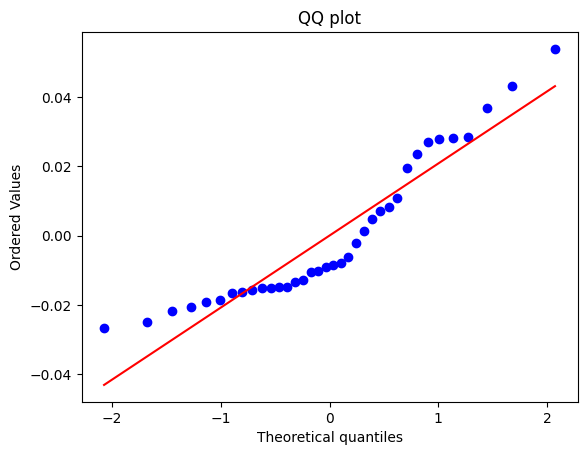

In [192]:
from scipy import stats

stats.probplot(all_resids, dist="norm", plot=plt)
plt.title("QQ plot")
plt.show()

In [285]:
# OLS and ANOVA with Tukey post-hoc
model = ols('rate ~ C(privacy)', data=test).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

tukey = pairwise_tukeyhsd(endog=test['rate'],
                          groups=test['privacy'],
                          alpha=0.0005)
print(tukey)

              sum_sq     df          F        PR(>F)
C(privacy)  0.347599    2.0  23.288333  4.258334e-09
Residual    0.783609  105.0        NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.00 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    ff     tf  -0.0248 0.4463 -0.1041  0.0546  False
    ff     tt  -0.1308    0.0 -0.2102 -0.0514   True
    tf     tt   -0.106    0.0 -0.1854 -0.0267   True
----------------------------------------------------


In [502]:
# Kruskal-Wallis and Dunn post-hoc
stat, p = kruskal(ttl, tfl, ffl)
print(f"{p:.10f} or {p}")
print(f"{stat:.10f}")

data = [ttl, tfl, ffl]
dunn_results = posthoc_dunn(data, p_adjust='bonferroni')
display(dunn_results)

dunn_results < 0.05

0.0000012016 or 1.2015526712462227e-06
27.2637918896


,1,2,3
1,1.000000,0.000036,0.00001
2,0.000036,1.000000,1.00000
3,0.000010,1.000000,1.00000


,1,2,3
1,False,True,True
2,True,False,False
3,True,False,False


In [106]:
# create table of averages/ CI

def output_diff(vdf, metric):
    tt = vdf[(vdf["personalization_on"]==True)&(vdf["activity_on"]==True)]
    tf = vdf[(vdf["personalization_on"]==True)&(vdf["activity_on"]==False)]
    ff = vdf[(vdf["personalization_on"]==False)&(vdf["activity_on"]==False)]

    ttl = np.array(tt[metric])
    tfl = np.array(tf[metric])
    ffl = np.array(ff[metric])

    test = pd.DataFrame({
        "tt":ttl,
        "tf":tfl,
        "ff":ffl
    })

#     indices = np.where(ttl==0)
    indices = []
    ttl = np.delete(ttl, indices)
    tfl = np.delete(tfl, indices)
    ffl = np.delete(ffl, indices)

    tf_diff = np.mean(tfl)/np.mean(ttl)
    ff_diff = np.mean(ffl)/np.mean(ttl)
    
    tf_mean = f"{tf_diff:.2f}"
    ff_mean = f"{ff_diff:.2f}"
    
    print(f'{tf_mean} & {ff_mean} & {len(ttl)} \\\\')

#     tfdf = pd.DataFrame(tf_diff).describe(include='all')
#     ffdf = pd.DataFrame(ff_diff).describe(include='all')

#     tf_mean = f"{float(tfdf.loc['mean']):.1f}"
#     tf_min = f"{float(tfdf.loc['min']):.1f}"
#     tf_max = f"{float(tfdf.loc['max']):.1f}"
#     tf_std = f"{float(tfdf.loc['std']):.1f}"

#     ff_mean = f"{float(ffdf.loc['mean']):.1f}"
#     ff_min = f"{float(ffdf.loc['min']):.1f}"
#     ff_max = f"{float(ffdf.loc['max']):.1f}"
#     ff_std = f"{float(ffdf.loc['std']):.1f}"

#     print(f'{tf_mean}, [{tf_min}, {tf_max}], SD = {tf_std} & {ff_mean}, [{ff_min}, {ff_max}], SD = {ff_std}\\\\')

# metric = "pr_ad_load"
# metric = "predatory_load"
# metric = "pr_scam_rate"
# metric = "all_ad_rate"
metric = "side_pv_load"


# vdf = df
# output_diff(vdf, metric)

# vsets = ["news", "entertainment", "science", "conspiracy"]
# for video_set in vsets:
#     vdf = df[df["video_set"]==video_set]
#     output_diff(vdf, metric)
    
    
locs = ["east", "central", "west"]
for loc in locs:
    vdf = df[df["location"]==loc]
    output_diff(vdf, metric)
    
    
# for run in range(1, 4):
#     vdf = df[df["run"]==run]
#     output_diff(vdf, metric)



1.28 & 1.40 & 12 \\
1.52 & 1.63 & 12 \\
1.57 & 1.70 & 12 \\


In [170]:
# create table of absolutes (no ratio)

def output(vdf, metric):

    tt = vdf[(vdf["personalization_on"]==True)&(vdf["activity_on"]==True)]
    tf = vdf[(vdf["personalization_on"]==True)&(vdf["activity_on"]==False)]
    ff = vdf[(vdf["personalization_on"]==False)&(vdf["activity_on"]==False)]

    ttl = np.array(tt[metric])
    tfl = np.array(tf[metric])
    ffl = np.array(ff[metric])

    test = pd.DataFrame({
        "tt":ttl,
        "tf":tfl,
        "ff":ffl
    })

#     indices = np.where(ttl==0)
#     print(indices[0])
    indices = []
    ttl = np.delete(ttl, indices)*100
    tfl = np.delete(tfl, indices)*100
    ffl = np.delete(ffl, indices)*100

    tfdf = pd.DataFrame(tfl).describe(include='all')
    ffdf = pd.DataFrame(ffl).describe(include='all')
    ttdf = pd.DataFrame(ttl).describe(include='all')

    tf_mean = f"{float(tfdf.loc['mean']):.1f}"
    tf_min = f"{float(tfdf.loc['min']):.1f}"
    tf_max = f"{float(tfdf.loc['max']):.1f}"
    tf_std = f"{float(tfdf.loc['std']):.1f}"

    ff_mean = f"{float(ffdf.loc['mean']):.1f}"
    ff_min = f"{float(ffdf.loc['min']):.1f}"
    ff_max = f"{float(ffdf.loc['max']):.1f}"
    ff_std = f"{float(ffdf.loc['std']):.1f}"

    tt_mean = f"{float(ttdf.loc['mean']):.1f}"
    tt_min = f"{float(ttdf.loc['min']):.1f}"
    tt_max = f"{float(ttdf.loc['max']):.1f}"
    tt_std = f"{float(ttdf.loc['std']):.1f}"

    print(f'{tt_mean}, [{tt_min}, {tt_max}], $\sigma = {tt_std}$ & {tf_mean}, [{tf_min}, {tf_max}], $\sigma = {tf_std}$  & {ff_mean}, [{ff_min}, {ff_max}], $\sigma = {ff_std}$ & {len(ttl)} \\\\')

    
    
# metric = "pr_ad_load"
# metric = "predatory_load"
# metric = "pr_scam_rate"
# metric = "all_ad_rate"
metric = "side_pv_load"


# vdf = df
# output(vdf, metric)

# vsets = ["news", "entertainment", "science", "conspiracy"]
# for video_set in vsets:
#     vdf = df[df["video_set"]==video_set]
#     output(vdf, metric)
    
    
locs = ["east", "central", "west"]
for loc in locs:
    vdf = df[df["location"]==loc]
    output(vdf, metric)
    
    
# for run in range(1, 4):
#     vdf = df[df["run"]==run]
#     output(vdf, metric)

    

18.5, [8.6, 33.6], $\sigma = 7.9$ & 23.7, [10.0, 48.9], $\sigma = 10.9$  & 26.0, [12.1, 40.1], $\sigma = 9.5$ & 12 \\
13.9, [3.2, 25.0], $\sigma = 7.7$ & 21.2, [10.3, 43.4], $\sigma = 9.8$  & 22.7, [10.3, 40.9], $\sigma = 8.8$ & 12 \\
15.2, [5.3, 23.9], $\sigma = 6.0$ & 24.0, [7.8, 43.8], $\sigma = 9.9$  & 25.9, [10.7, 49.3], $\sigma = 10.6$ & 12 \\


In [85]:
np.mean(ffl/ttl)

6.850104639398294

In [129]:
# create raw tables

locs = ["east", "central", "west"]

vsets = ["news", "entertainment", "science", "conspiracy"]
video_set = vsets[3]
vdf = df[df["video_set"]==video_set]

tt = vdf[(vdf["personalization_on"]==True)&(vdf["activity_on"]==True)]
tf = vdf[(vdf["personalization_on"]==True)&(vdf["activity_on"]==False)]
ff = vdf[(vdf["personalization_on"]==False)&(vdf["activity_on"]==False)]

ls = [tt, tf, ff]
for setting in ls:
    for loc in locs:
        for run in range(1, 4):
            row = setting[(setting["location"]==loc) & (setting["run"]==run)]
            print(f"{int(row['pr_count'])}   {float(row['pr_scam_rate']):.4f}   {int(row['side_count'])}   {int(row['promoted_vid_count'])}")

178   0.0787   227   31
181   0.0718   366   36
228   0.0921   975   34
195   0.0667   245   41
315   0.0698   207   34
212   0.0896   701   47
177   0.1017   280   44
201   0.0597   250   32
218   0.0872   561   41
276   0.2319   687   12
285   0.3789   612   16
298   0.4027   1217   20
277   0.1552   568   10
349   0.2350   1072   42
323   0.2291   1277   26
274   0.2956   716   20
322   0.2360   1112   17
335   0.3672   1293   22
292   0.3801   1035   33
317   0.2934   1177   25
308   0.2987   1107   64
377   0.3130   789   14
345   0.2319   1083   30
325   0.2923   1185   42
285   0.3088   903   16
324   0.2284   1095   19
333   0.3694   1453   27
